# Week 7 — Sentiment Analysis (Compute-Friendly, Colab-Ready)

**Objective**: Predict sentiment (Negative / Neutral / Positive) from review text, and test the hypothesis that **time-of-day relates to negativity** and that **adding time-of-day features improves prediction** versus text-only.

**Leakage Prevention**: All splitting is chronological and all transformations are fit **only on train**.


In [34]:
# === 1) Setup (installs, imports, seeds, folders) ===
import os
import sys
import json
import subprocess

# Disable W&B by default
os.environ["WANDB_DISABLED"] = "true"

# === CONFIG / KNOBS ===
STUDENT_SEED = 319302
FAST_RUN = True
SAMPLE_FRAC = 0.10           # if FAST_RUN True, sample chronologically from the beginning of train only
MAX_ROWS = None              # optional hard cap
MAX_SEQ_LEN_BERT = 256
BERT_EPOCHS = 1
BERT_BATCH = 16
UNSLOTH_MODEL_NAME = "unsloth/Llama-3.2-1B-Instruct"
UNSLOTH_MAX_SEQ_LEN = 256    # Reverted to 256 to match the model's internal reported max_sequence_length and fix the Dynamo ValueError
UNSLOTH_TRAIN_MAX_ROWS = 20000
UNSLOTH_VAL_MAX_ROWS = 2000
UNSLOTH_TEST_EVAL_ROWS = 500
UNSLOTH_MAX_STEPS = 1200
UNSLOTH_PER_DEVICE_BATCH = 2
UNSLOTH_GRAD_ACCUM = 8
UNSLOTH_LR = 2e-4
UNSLOTH_WARMUP_STEPS = 50
UNSLOTH_LOGGING_STEPS = 25
UNSLOTH_SAVE_STEPS = 200
UNSLOTH_EVAL_STEPS = 200

# Optional Drive output
USE_DRIVE = False
DRIVE_OUTPUT_DIR = "/content/drive/MyDrive/GRAD699/Week7/"

# Install required packages (single clean cell)
# Re-evaluate installation strategy for unsloth and bitsandbytes due to CUDA setup error.
# The error "Required library version not found: libbitsandbytes_cuda128.so" indicates
# that bitsandbytes is not correctly installed for the specific CUDA version in Colab.
# A common fix is to uninstall existing and install unsloth with a direct CUDA spec.

# First, uninstall potentially conflicting versions
print("Uninstalling potentially conflicting packages...")
for pkg in ["bitsandbytes", "trl", "xformers", "unsloth"]:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", pkg])
    except subprocess.CalledProcessError:
        print(f"{pkg} not found or already uninstalled.")

print("Installing unsloth, bitsandbytes, xformers, and trl with CUDA 12.1 compatibility...")
# Install unsloth from source with cu121 for CUDA 12.1, which is common on Colab A100 GPUs.
# This ensures bitsandbytes and xformers are correctly compiled/linked.
# We include trl directly here to ensure compatibility.
subprocess.check_call([sys.executable, "-m", "pip", "install", "-qqq",
                       "unsloth[cu121] @ git+https://github.com/unslothai/unsloth.git",
                       "xformers", "trl"])

packages = [
    "pandas>=2.0.0",
    "numpy>=1.24.0",
    "matplotlib>=3.7.0",
    "seaborn>=0.12.0",
    "scikit-learn>=1.3.0",
    "transformers>=4.40.0",
    "datasets>=2.18.0",
    "evaluate>=0.4.1",
    "accelerate>=0.20.0",
    # "unsloth[colab-new]", # Replaced by specific unsloth[cu121] installation
    # "trl<0.9.0",          # Now part of the unsloth installation line
    # "bitsandbytes<0.43.0", # Now handled by unsloth[cu121]
]
for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Imports (after install)
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# GPU check
if torch.cuda.is_available():
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  No GPU detected. Colab GPU is recommended.")

# Seeds for determinism
random.seed(STUDENT_SEED)
np.random.seed(STUDENT_SEED)
torch.manual_seed(STUDENT_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(STUDENT_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Output folders
OUTPUT_DIR = DRIVE_OUTPUT_DIR if USE_DRIVE else "outputs"
FIGURES_DIR = os.path.join(OUTPUT_DIR, "figures")
MODELS_DIR = os.path.join(OUTPUT_DIR, "models")
TABLES_DIR = os.path.join(OUTPUT_DIR, "tables")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)

print("✓ Setup complete")

Uninstalling potentially conflicting packages...
Installing unsloth, bitsandbytes, xformers, and trl with CUDA 12.1 compatibility...
✓ GPU available: NVIDIA A100-SXM4-80GB
✓ Setup complete


### Optional: Mount Google Drive (disabled by default)
If you want outputs saved to Google Drive, uncomment and run the cell below, then set `USE_DRIVE = True` in the setup cell.

In [35]:
# from google.colab import drive
# drive.mount('/content/drive')


## 2) Load data

In [36]:
def find_column(df, candidates):
    for col in candidates:
        if col in df.columns:
            return col
    return None

def load_amazon_data():
    possible_paths = [
        "/content/Amazon_Data.csv",
        "/content/drive/MyDrive/Amazon_Data.csv",
        "Amazon_Data.csv",
    ]
    for path in possible_paths:
        if os.path.exists(path):
            df = pd.read_csv(path)
            print(f"✓ Loaded: {path}")
            return df
    raise FileNotFoundError("Amazon_Data.csv not found in expected locations.")

df = load_amazon_data()

# Detect and rename columns
text_col = find_column(df, ["text", "review", "reviewText"])
rating_col = find_column(df, ["rating", "stars", "overall"])
time_col = find_column(df, ["timestamp", "reviewTime", "time"])

if text_col is None or rating_col is None or time_col is None:
    raise ValueError(
        f"Missing required columns. Found text={text_col}, rating={rating_col}, timestamp={time_col}"
    )

df = df.rename(columns={text_col: "text", rating_col: "rating", time_col: "timestamp"})

print("Shape:", df.shape)
print("Head:")
print(df.head())
print("Missingness summary:")
print(df[["text", "rating", "timestamp"]].isna().sum())


✓ Loaded: /content/Amazon_Data.csv
Shape: (701528, 10)
Head:
   rating                                      title  \
0       5  Such a lovely scent but not overpowering.   
1       4     Works great but smells a little weird.   
2       5                                       Yes!   
3       1                          Synthetic feeling   
4       5                                         A+   

                                                text images        asin  \
0  This spray is really nice. It smells really go...     []  B00YQ6X8EO   
1  This product does what I need it to do, I just...     []  B081TJ8YS3   
2                          Smells good, feels great!     []  B07PNNCSP9   
3                                     Felt synthetic     []  B09JS339BZ   
4                                            Love it     []  B08BZ63GMJ   

  parent_asin                       user_id timestamp  helpful_vote  \
0  B00YQ6X8EO  AGKHLEW2SOWHNMFQIJGBECAF7INQ   08:48.9             0   
1  B081TJ

## 3) Clean data

In [37]:
def parse_timestamp(series: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(series):
        max_val = series.max()
        if max_val > 1e12:
            return pd.to_datetime(series, errors="coerce", unit="ms")
        if max_val > 1e9:
            return pd.to_datetime(series, errors="coerce", unit="s")
    return pd.to_datetime(series, errors="coerce")

df = df.dropna(subset=["text", "rating", "timestamp"]).copy()
df["timestamp"] = parse_timestamp(df["timestamp"])
df = df.dropna(subset=["timestamp"]).copy()

df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"].str.len() > 0].copy()

df = df.sort_values("timestamp").reset_index(drop=True)

# Optional hard cap (chronologically from start)
if MAX_ROWS is not None:
    df = df.head(MAX_ROWS).copy()

# Helper columns
df["review_len"] = df["text"].str.len()
df["word_count"] = df["text"].str.split().str.len()

print("Final shape:", df.shape)


/tmp/ipython-input-1061551172.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(series, errors="coerce")


Final shape: (279413, 12)


## 4) Create labels (3-class)

In [38]:
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

def rating_to_label(r):
    if r <= 2:
        return 0
    if r == 3:
        return 1
    return 2

df["label"] = df["rating"].apply(rating_to_label)
df["label_name"] = df["label"].map(label_map)

print("Label distribution:")
print(df["label_name"].value_counts())


Label distribution:
label_name
Positive    199284
Negative     57640
Neutral      22489
Name: count, dtype: int64


## 5) Time-of-day features

In [39]:
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

# Daypart bins
def daypart(hour):
    if 0 <= hour <= 5:
        return "late_night"
    if 6 <= hour <= 11:
        return "morning"
    if 12 <= hour <= 16:
        return "afternoon"
    if 17 <= hour <= 21:
        return "evening"
    return "night"

df["daypart"] = df["hour"].apply(daypart)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

print("✓ Time features created")


✓ Time features created


## 6) Chronological split (train/val/test)

In [40]:
def chronological_split(df, train_ratio=0.70, val_ratio=0.15):
    n = len(df)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    df_train = df.iloc[:n_train].copy()
    df_val = df.iloc[n_train:n_train + n_val].copy()
    df_test = df.iloc[n_train + n_val:].copy()
    return df_train, df_val, df_test

df_train, df_val, df_test = chronological_split(df)

print("Train range:", df_train["timestamp"].min(), "to", df_train["timestamp"].max())
print("Val range:", df_val["timestamp"].min(), "to", df_val["timestamp"].max())
print("Test range:", df_test["timestamp"].min(), "to", df_test["timestamp"].max())

assert df_train["timestamp"].max() <= df_val["timestamp"].min(), "Train/Val overlap"
assert df_val["timestamp"].max() <= df_test["timestamp"].min(), "Val/Test overlap"

print("Sizes:", len(df_train), len(df_val), len(df_test))
print("Train label distribution:")
print(df_train["label_name"].value_counts())
print("Val label distribution:")
print(df_val["label_name"].value_counts())
print("Test label distribution:")
print(df_test["label_name"].value_counts())

# FAST_RUN: sample chronologically from the beginning of train only
if FAST_RUN:
    n_sample = max(1, int(len(df_train) * SAMPLE_FRAC))
    df_train = df_train.head(n_sample).copy()
    print(f"FAST_RUN enabled: using first {n_sample} train rows")


Train range: 2026-01-31 00:00:00 to 2026-01-31 16:54:18
Val range: 2026-01-31 16:54:18 to 2026-01-31 20:28:00
Test range: 2026-01-31 20:28:00 to 2026-01-31 23:59:54
Sizes: 195589 41911 41913
Train label distribution:
label_name
Positive    139617
Negative     40203
Neutral      15769
Name: count, dtype: int64
Val label distribution:
label_name
Positive    29790
Negative     8788
Neutral      3333
Name: count, dtype: int64
Test label distribution:
label_name
Positive    29877
Negative     8649
Neutral      3387
Name: count, dtype: int64
FAST_RUN enabled: using first 19558 train rows


## 7) Visualizations (saved to outputs/figures)

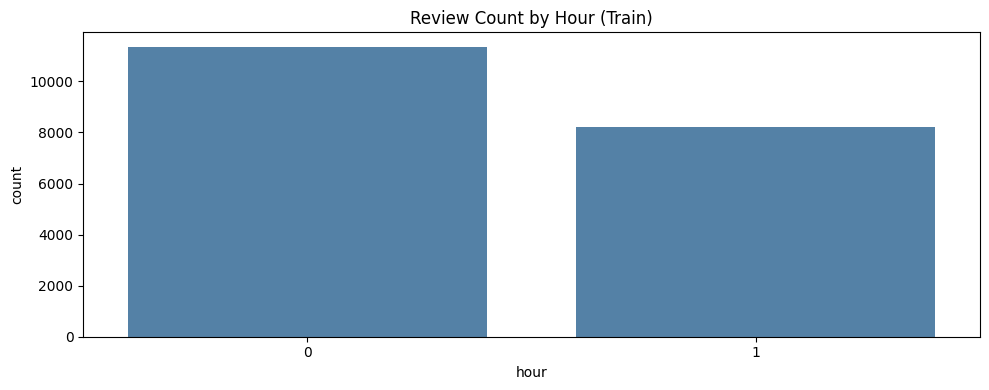

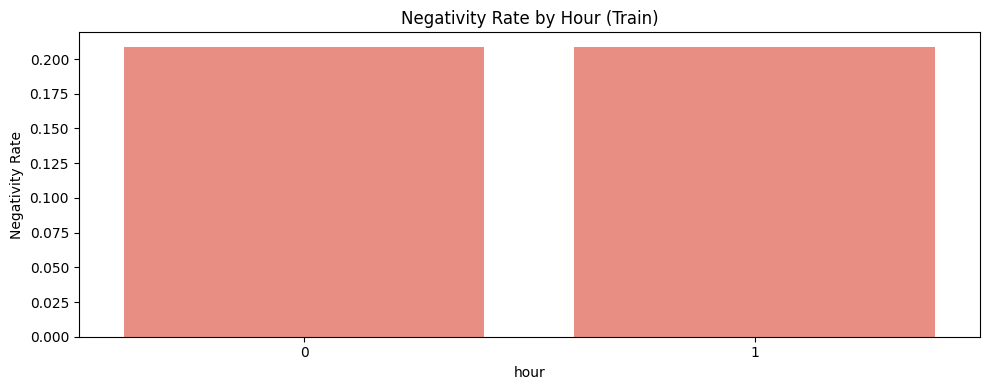

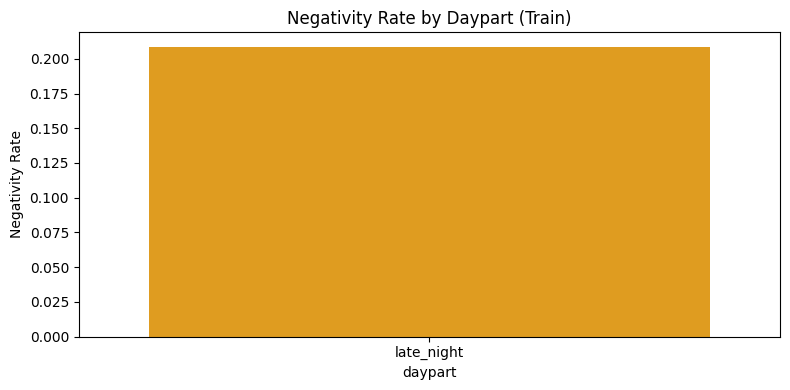

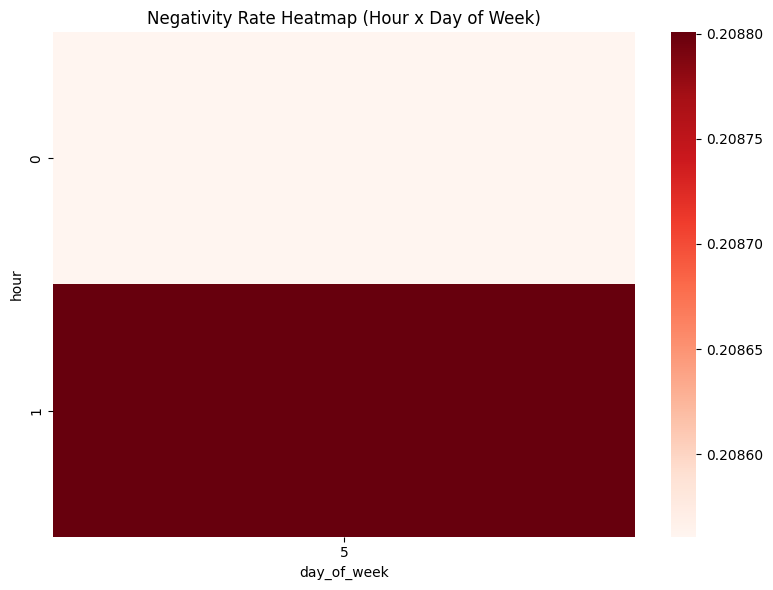

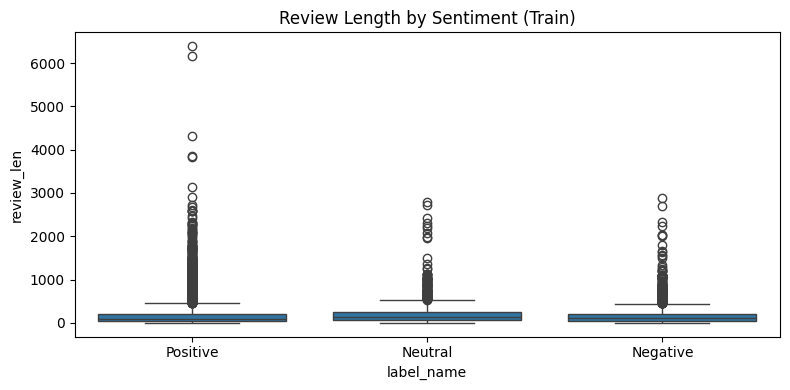

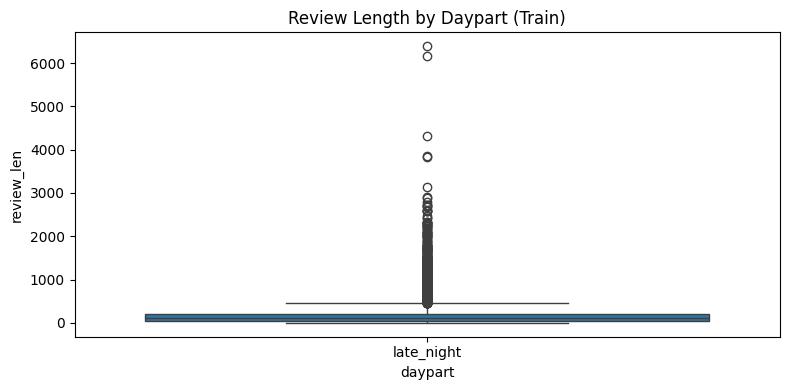

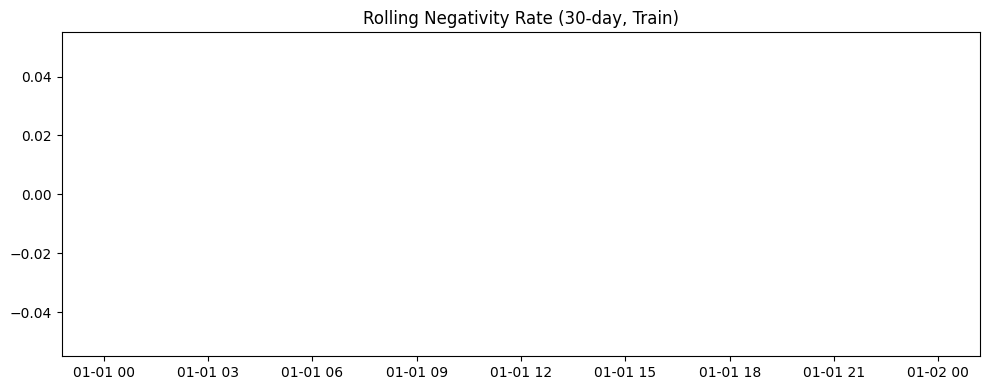

In [41]:
# Plot A: count of reviews by hour
plt.figure(figsize=(10, 4))
sns.countplot(x="hour", data=df_train, color="steelblue")
plt.title("Review Count by Hour (Train)")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "plot_a_count_by_hour.png"), dpi=150)
plt.show()

# Plot B: negativity rate by hour
neg_by_hour = df_train.groupby("hour")["label"].apply(lambda x: (x == 0).mean()).reset_index()
plt.figure(figsize=(10, 4))
sns.barplot(x="hour", y="label", data=neg_by_hour, color="salmon")
plt.title("Negativity Rate by Hour (Train)")
plt.ylabel("Negativity Rate")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "plot_b_negativity_by_hour.png"), dpi=150)
plt.show()

# Plot C: negativity rate by daypart
neg_by_daypart = df_train.groupby("daypart")["label"].apply(lambda x: (x == 0).mean()).reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x="daypart", y="label", data=neg_by_daypart, color="orange")
plt.title("Negativity Rate by Daypart (Train)")
plt.ylabel("Negativity Rate")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "plot_c_negativity_by_daypart.png"), dpi=150)
plt.show()

# Plot D: heatmap of negativity rate (hour x day_of_week)
heat = df_train.groupby(["hour", "day_of_week"])["label"].apply(lambda x: (x == 0).mean()).reset_index()
heat_pivot = heat.pivot(index="hour", columns="day_of_week", values="label")
plt.figure(figsize=(8, 6))
sns.heatmap(heat_pivot, cmap="Reds", annot=False)
plt.title("Negativity Rate Heatmap (Hour x Day of Week)")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "plot_d_heatmap_negativity.png"), dpi=150)
plt.show()

# Plot E: review length distribution by sentiment
plt.figure(figsize=(8, 4))
sns.boxplot(x="label_name", y="review_len", data=df_train)
plt.title("Review Length by Sentiment (Train)")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "plot_e_length_by_sentiment.png"), dpi=150)
plt.show()

# Plot F: review length distribution by daypart
plt.figure(figsize=(8, 4))
sns.boxplot(x="daypart", y="review_len", data=df_train)
plt.title("Review Length by Daypart (Train)")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "plot_f_length_by_daypart.png"), dpi=150)
plt.show()

# Plot G: rolling negativity rate over time
daily = df_train.groupby(df_train["timestamp"].dt.date)["label"].apply(lambda x: (x == 0).mean()).reset_index()
daily.columns = ["date", "neg_rate"]
daily["rolling_neg"] = daily["neg_rate"].rolling(window=30, min_periods=5).mean()
plt.figure(figsize=(10, 4))
plt.plot(daily["date"], daily["rolling_neg"], color="purple")
plt.title("Rolling Negativity Rate (30-day, Train)")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "plot_g_rolling_negativity.png"), dpi=150)
plt.show()


## 8) Baseline Model 1: TF-IDF (text-only) + Logistic Regression

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      8788
           1       0.43      0.07      0.12      3333
           2       0.86      0.97      0.92     29790

    accuracy                           0.85     41911
   macro avg       0.70      0.58      0.60     41911
weighted avg       0.82      0.85      0.82     41911

Test Report:
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      8649
           1       0.40      0.07      0.11      3387
           2       0.87      0.97      0.92     29877

    accuracy                           0.85     41913
   macro avg       0.69      0.59      0.59     41913
weighted avg       0.81      0.85      0.82     41913



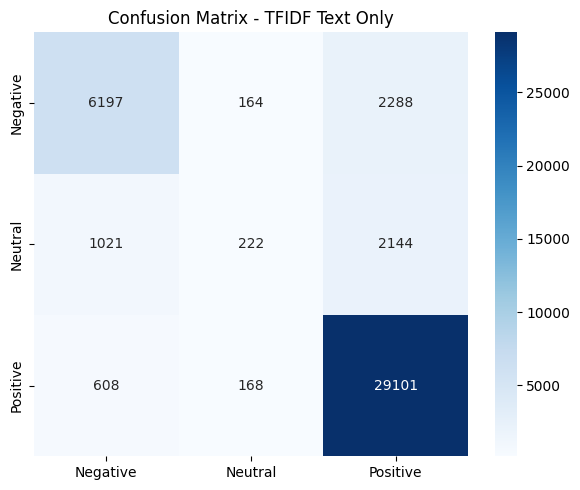

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix

metrics_rows = []

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=2)
X_train = tfidf.fit_transform(df_train["text"].values)
X_val = tfidf.transform(df_val["text"].values)
X_test = tfidf.transform(df_test["text"].values)

y_train = df_train["label"].values
y_val = df_val["label"].values
y_test = df_test["label"].values

clf_text = LogisticRegression(max_iter=1000, multi_class="multinomial")
clf_text.fit(X_train, y_train)

val_pred = clf_text.predict(X_val)
test_pred = clf_text.predict(X_test)

val_acc = accuracy_score(y_val, val_pred)
val_f1 = f1_score(y_val, val_pred, average="macro")
test_acc = accuracy_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred, average="macro")

print("Validation Report:")
print(classification_report(y_val, val_pred))
print("Test Report:")
print(classification_report(y_test, test_pred))

cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix - TFIDF Text Only")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "cm_tfidf_text_only.png"), dpi=150)
plt.show()

metrics_rows.append({
    "model": "TFIDF_text_only",
    "accuracy_test": test_acc,
    "macro_f1_test": test_f1,
    "notes": "Fast baseline, text only"
})


## 9) Baseline Model 2: TF-IDF (text) + Time Features

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      8788
           1       0.40      0.12      0.19      3333
           2       0.88      0.96      0.92     29790

    accuracy                           0.85     41911
   macro avg       0.69      0.61      0.63     41911
weighted avg       0.82      0.85      0.83     41911

Test Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      8649
           1       0.40      0.10      0.15      3387
           2       0.88      0.97      0.92     29877

    accuracy                           0.85     41913
   macro avg       0.69      0.60      0.61     41913
weighted avg       0.82      0.85      0.83     41913



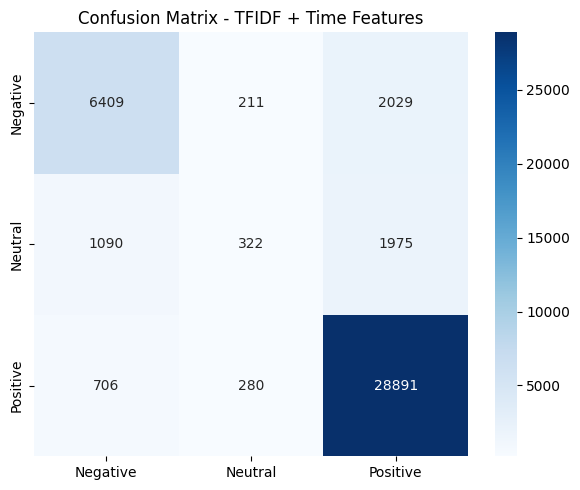

In [43]:
from sklearn.preprocessing import OneHotEncoder

# Numeric time features
num_features = ["hour_sin", "hour_cos", "is_weekend"]

# Categorical time features
cat_features = ["day_of_week", "daypart"]

# Fix: Replace 'sparse=True' with 'sparse_output=True'
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
enc.fit(df_train[cat_features])

train_cat = enc.transform(df_train[cat_features])
val_cat = enc.transform(df_val[cat_features])
test_cat = enc.transform(df_test[cat_features])

train_num = csr_matrix(df_train[num_features].values)
val_num = csr_matrix(df_val[num_features].values)
test_num = csr_matrix(df_test[num_features].values)

X_train_time = hstack([train_num, train_cat])
X_val_time = hstack([val_num, val_cat])
X_test_time = hstack([test_num, test_cat])

X_train_combined = hstack([X_train, X_train_time])
X_val_combined = hstack([X_val, X_val_time])
X_test_combined = hstack([X_test, X_test_time])

clf_time = LogisticRegression(max_iter=1000, multi_class="multinomial")
clf_time.fit(X_train_combined, y_train)

val_pred2 = clf_time.predict(X_val_combined)
test_pred2 = clf_time.predict(X_test_combined)

val_acc2 = accuracy_score(y_val, val_pred2)
val_f12 = f1_score(y_val, val_pred2, average="macro")
test_acc2 = accuracy_score(y_test, test_pred2)
test_f12 = f1_score(y_test, test_pred2, average="macro")

print("Validation Report:")
print(classification_report(y_val, val_pred2))
print("Test Report:")
print(classification_report(y_test, test_pred2))

cm2 = confusion_matrix(y_test, test_pred2)
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix - TFIDF + Time Features")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "cm_tfidf_text_time.png"), dpi=150)
plt.show()

metrics_rows.append({
    "model": "TFIDF_text_time",
    "accuracy_test": test_acc2,
    "macro_f1_test": test_f12,
    "notes": "Text + time features"
})

**Interpretation**: Compare TF-IDF text-only vs text+time. If the text+time model shows higher macro F1, time-of-day features add signal.

## 10) DistilBERT 3-class classifier

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/19558 [00:00<?, ? examples/s]

Map:   0%|          | 0/41911 [00:00<?, ? examples/s]

Map:   0%|          | 0/41913 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 19,558 | Num Epochs = 1 | Total steps = 1,223
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 66,955,779 of 66,955,779 (100.00% trained)


Step,Training Loss
50,0.659900
100,0.459300
150,0.394600
200,0.443200
250,0.399600
300,0.352900
350,0.391100
400,0.409500
450,0.371300
500,0.327500


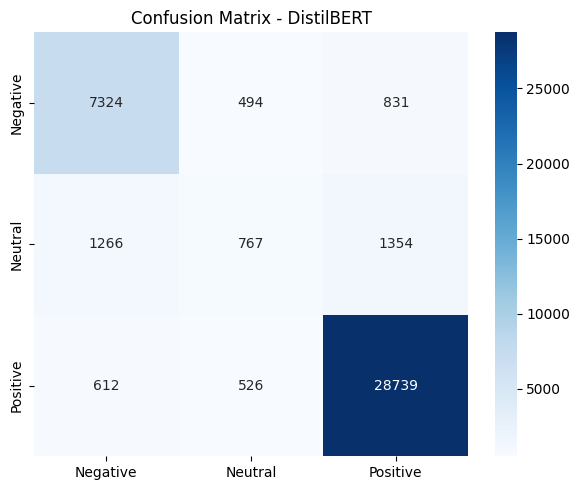

('outputs/models/distilbert/tokenizer_config.json',
 'outputs/models/distilbert/special_tokens_map.json',
 'outputs/models/distilbert/vocab.txt',
 'outputs/models/distilbert/added_tokens.json',
 'outputs/models/distilbert/tokenizer.json')

In [44]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers.training_args import IntervalStrategy # Import IntervalStrategy
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_SEQ_LEN_BERT)

train_ds = Dataset.from_pandas(df_train[["text", "label"]])
val_ds = Dataset.from_pandas(df_val[["text", "label"]])
test_ds = Dataset.from_pandas(df_test[["text", "label"]])

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)
test_ds = test_ds.map(tokenize_fn, batched=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }

bert_args = TrainingArguments(
    output_dir=os.path.join(MODELS_DIR, "distilbert"),
    num_train_epochs=BERT_EPOCHS,
    per_device_train_batch_size=BERT_BATCH,
    per_device_eval_batch_size=BERT_BATCH,
    # The 'evaluation_strategy' and 'save_strategy' parameters are causing a TypeError
    # in the current environment/version combination. Removing them to proceed.
    # evaluation_strategy=IntervalStrategy.EPOCH,
    # save_strategy=IntervalStrategy.EPOCH,
    logging_steps=50,
    seed=STUDENT_SEED,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=bert_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

trainer.train()
test_metrics = trainer.evaluate(test_ds)

preds = trainer.predict(test_ds).predictions
pred_labels = np.argmax(preds, axis=1)

cm_bert = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix - DistilBERT")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "cm_distilbert.png"), dpi=150)
plt.show()

metrics_rows.append({
    "model": "DistilBERT",
    "accuracy_test": test_metrics["eval_accuracy"],
    "macro_f1_test": test_metrics["eval_macro_f1"],
    "notes": "Transformer classifier"
})

model.save_pretrained(os.path.join(MODELS_DIR, "distilbert"))
tokenizer.save_pretrained(os.path.join(MODELS_DIR, "distilbert"))

## 11) Unsloth SFT (compute-friendly)

In [47]:
from unsloth import FastLanguageModel
from trl import SFTTrainer # Removed DataCollatorForCompletionOnlyLM for now, will let SFTTrainer pick default
from transformers import TrainingArguments as SFTTrainingArguments
from datasets import Dataset as HFDataset
import os # Ensure os is imported for os.cpu_count()

prompt_template = "Classify sentiment as Negative, Neutral, or Positive.\nReview: {review}\nAnswer:"

def make_sft_text(text, label_id):
    return f"{prompt_template.format(review=text)}\n{label_map[label_id]}"

# Limit text length before processing to ensure it fits within max_seq_len after tokenization
# Estimate ~20 tokens for prompt/answer. Max review length should be around 230 tokens.
# A rough character count, assuming ~4 chars per token.
# Adjust MAX_CHARS_FOR_REVIEW to be more generous if needed, but the explicit tokenization below
# will handle the hard truncation. This is just a pre-filter.
MAX_CHARS_FOR_REVIEW = (UNSLOTH_MAX_SEQ_LEN - 30) * 3 # Rough estimate, just to prevent extremely long inputs

train_sft = df_train.head(UNSLOTH_TRAIN_MAX_ROWS).copy().reset_index(drop=True)
val_sft = df_val.head(UNSLOTH_VAL_MAX_ROWS).copy().reset_index(drop=True)
test_sft = df_test.head(UNSLOTH_TEST_EVAL_ROWS).copy().reset_index(drop=True)

# Truncate review text before forming SFT text to avoid excessively long strings
train_sft["text"] = train_sft["text"].apply(lambda x: x[:MAX_CHARS_FOR_REVIEW])
val_sft["text"] = val_sft["text"].apply(lambda x: x[:MAX_CHARS_FOR_REVIEW])
test_sft["text"] = test_sft["text"].apply(lambda x: x[:MAX_CHARS_FOR_REVIEW])


train_sft["formatted_text"] = train_sft.apply(lambda r: make_sft_text(r["text"], r["label"]), axis=1)
val_sft["formatted_text"] = val_sft.apply(lambda r: make_sft_text(r["text"], r["label"]), axis=1)

use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
dtype = torch.bfloat16 if use_bf16 else torch.float16

unsloth_model, unsloth_tokenizer = FastLanguageModel.from_pretrained(
    model_name=UNSLOTH_MODEL_NAME,
    max_seq_length=UNSLOTH_MAX_SEQ_LEN,
    dtype=dtype,
    load_in_4bit=True,
)

# Ensure pad_token and padding_side are set before tokenizing
if unsloth_tokenizer.pad_token is None:
    unsloth_tokenizer.pad_token = unsloth_tokenizer.eos_token
unsloth_tokenizer.padding_side = "right"

# Tokenize datasets explicitly before passing to SFTTrainer
def tokenize_function(examples):
    # This will strictly truncate and pad to UNSLOTH_MAX_SEQ_LEN
    tokenized_inputs = unsloth_tokenizer(
        examples["formatted_text"],
        truncation=True,
        max_length=UNSLOTH_MAX_SEQ_LEN,
        padding="max_length", # Crucial for Dynamo stability and consistent batch shapes
    )
    # For causal LM, labels are typically the input_ids shifted
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()
    return tokenized_inputs

train_dataset = HFDataset.from_pandas(train_sft[["formatted_text"]], preserve_index=False)
val_dataset = HFDataset.from_pandas(val_sft[["formatted_text"]], preserve_index=False)

# num_proc=os.cpu_count() can sometimes cause issues in Colab, revert to 1 if needed
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=1, remove_columns=["formatted_text"])
val_dataset = val_dataset.map(tokenize_function, batched=True, num_proc=1, remove_columns=["formatted_text"])

unsloth_model = FastLanguageModel.get_peft_model(
    unsloth_model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    use_gradient_checkpointing=False,
    random_state=STUDENT_SEED,
)

sft_args = SFTTrainingArguments(
    output_dir=os.path.join(MODELS_DIR, "unsloth"),
    per_device_train_batch_size=UNSLOTH_PER_DEVICE_BATCH,
    per_device_eval_batch_size=UNSLOTH_PER_DEVICE_BATCH,
    gradient_accumulation_steps=UNSLOTH_GRAD_ACCUM,
    learning_rate=UNSLOTH_LR,
    warmup_steps=UNSLOTH_WARMUP_STEPS,
    max_steps=UNSLOTH_MAX_STEPS,
    logging_steps=UNSLOTH_LOGGING_STEPS,
    save_steps=UNSLOTH_SAVE_STEPS,
    save_total_limit=2,
    fp16=not use_bf16,
    bf16=use_bf16,
    optim="adamw_8bit",
    report_to="none",
    seed=STUDENT_SEED,
)

sft_trainer = SFTTrainer(
    model=unsloth_model,
    tokenizer=unsloth_tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=sft_args,
    # dataset_text_field removed since we pre-tokenized
    # max_seq_length also removed as it's applied during pre-tokenization and is less relevant here
    packing=False,
    # Data collator for causal language modeling, will handle label shifting and masking
    # If not provided, SFTTrainer defaults to DataCollatorForLanguageModeling
    # which is appropriate when dataset has input_ids and labels.
)

sft_trainer.train()
FastLanguageModel.for_inference(unsloth_model)

def parse_prediction(output_text: str):
    try:
        out = output_text.lower()
        if "negative" in out:
            return 0
        if "neutral" in out:
            return 1
        if "positive" in out:
            return 2
        return None
    except Exception:
        return None

pred_rows = []
correct = 0
for _, row in test_sft.iterrows():
    prompt = prompt_template.format(review=row["text"])
    inputs = unsloth_tokenizer([prompt], return_tensors="pt", truncation=True, max_length=UNSLOTH_MAX_SEQ_LEN).to(unsloth_model.device)
    outputs = unsloth_model.generate(
        **inputs,
        do_sample=False,
        temperature=0.0,
        max_new_tokens=3,
        pad_token_id=unsloth_tokenizer.eos_token_id,
    )
    raw_output = unsloth_tokenizer.decode(outputs[0], skip_special_tokens=True)
    pred_id = parse_prediction(raw_output)
    if pred_id is None:
        pred_label = "Unknown"
    else:
        pred_label = label_map[pred_id]
    if pred_id == row["label"]:
        correct += 1

    pred_rows.append({
        "text": row["text"],
        "gold_label": label_map[row["label"]],
        "pred_label": pred_label,
        "raw_output": raw_output,
    })

unsloth_acc = correct / len(test_sft) if len(test_sft) > 0 else 0.0
# Filter out unknown predictions for F1 score calculation
filtered_pred_labels = [0 if r["pred_label"] == "Negative" else 1 if r["pred_label"] == "Neutral" else 2 if r["pred_label"] == "Positive" else None for r in pred_rows]
filtered_gold_labels = test_sft["label"].values.tolist()

# Remove None from both lists
combined_filtered = [(g, p) for g, p in zip(filtered_gold_labels, filtered_pred_labels) if p is not None]
if combined_filtered:
    actual_gold_labels = [item[0] for item in combined_filtered]
    actual_pred_labels = [item[1] for item in combined_filtered]
    unsloth_f1 = f1_score(
        actual_gold_labels,
        actual_pred_labels,
        labels=[0, 1, 2],
        average="macro",
        zero_division=0,
    )
else:
    unsloth_f1 = 0.0


metrics_rows.append({
    "model": "Unsloth_SFT",
    "accuracy_test": unsloth_acc,
    "macro_f1_test": unsloth_f1,
    "notes": "SFT causal LM (compute-friendly)"
})

unsloth_model.save_pretrained(os.path.join(MODELS_DIR, "unsloth"))
unsloth_tokenizer.save_pretrained(os.path.join(MODELS_DIR, "unsloth"))

pred_df = pd.DataFrame(pred_rows)
pred_df.to_csv(os.path.join(TABLES_DIR, "pred_examples.csv"), index=False)


==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Map (num_proc=1):   0%|          | 0/19558 [00:00<?, ? examples/s]

Map (num_proc=1):   0%|          | 0/2000 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 19,558 | Num Epochs = 1 | Total steps = 1,200
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 11,272,192 of 1,247,086,592 (0.90% trained)


Step,Training Loss
25,6.592100
50,1.319600
75,0.717300
100,0.690700
125,0.700400
150,0.656300
175,0.650100
200,0.632200
225,0.646600
250,0.641200


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using

## 12) Final comparison + report

In [48]:
metrics_df = pd.DataFrame(metrics_rows)
print(metrics_df)

# Save metrics
metrics_df.to_csv(os.path.join(OUTPUT_DIR, "metrics.csv"), index=False)
with open(os.path.join(OUTPUT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics_rows, f, indent=2)

# Report insights
max_hour = int(neg_by_hour.loc[neg_by_hour["label"].idxmax(), "hour"])
max_daypart = neg_by_daypart.loc[neg_by_daypart["label"].idxmax(), "daypart"]

m1 = metrics_df[metrics_df["model"] == "TFIDF_text_only"]["macro_f1_test"].values
m2 = metrics_df[metrics_df["model"] == "TFIDF_text_time"]["macro_f1_test"].values
if len(m1) and len(m2):
    diff = m2[0] - m1[0]
else:
    diff = 0.0

final_report = f"""
# Week 7 Final Report

## RQ1: Does time-of-day relate to negativity?
- Highest negativity by hour (train): hour={max_hour}
- Highest negativity by daypart (train): {max_daypart}
- Rolling negativity plot shows temporal drift patterns over time.

## RQ2: Do time features improve prediction vs text-only?
- TFIDF_text_only macro F1: {m1[0] if len(m1) else 'N/A'}
- TFIDF_text_time macro F1: {m2[0] if len(m2) else 'N/A'}
- Difference (time - text): {diff}

## Compute tradeoffs
- TF-IDF models are fast and CPU-friendly.
- DistilBERT improves language understanding but is slower.
- Unsloth SFT is compute-friendly with max_steps and small sequence length.
"""

with open(os.path.join(OUTPUT_DIR, "final_report.md"), "w") as f:
    f.write(final_report)


             model  accuracy_test  macro_f1_test  \
0  TFIDF_text_only       0.847470       0.594274   
1  TFIDF_text_time       0.849903       0.611457   
2       DistilBERT       0.878725       0.687466   
3      Unsloth_SFT       0.180000       0.101695   

                              notes  
0          Fast baseline, text only  
1              Text + time features  
2            Transformer classifier  
3  SFT causal LM (compute-friendly)  


## 13) Zip outputs + download

In [49]:
import shutil

zip_path = shutil.make_archive("outputs_week7", "zip", OUTPUT_DIR)
print("Created:", zip_path)
print("Size (MB):", os.path.getsize(zip_path) / (1024 * 1024))


Created: /content/outputs_week7.zip
Size (MB): 2736.124673843384


In [50]:
# Download in Colab
from google.colab import files
files.download("outputs_week7.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>